In [ ]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- skewed Bernoulli map & simulator ---
def f_SB(x, b):
    return np.where(x <= 1/b, b * x, (b * x - 1) / (b - 1))

def df_SB(x, b):
    return np.where(x <= 1/b, b, b / (b - 1))

def simulate_y_trajectories(N=100, T=1000, epsilon=0.7, b=4.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    y = np.random.rand(N)
    y_history = np.zeros((T, N))
    for t in range(T):
        y_mean = np.mean(y)
        input_y = (1 - epsilon) * y + epsilon * y_mean
        y = f_SB(input_y, b)
        y_history[t] = y
    return y_history

# --- helpers ---
def summary_stats(y):
    return float(np.mean(y)), float(np.std(y))

def mean_vline(mean_val, ymax):
    return go.layout.Shape(
        type="line", x0=mean_val, x1=mean_val, y0=0, y1=ymax,
        line=dict(color="black", dash="dash"), xref="x", yref="y"
    )

# ---------------- Option A: final-time histogram ----------------
def plot_hist_final(y_history, time_idx=None, nbins=40, title=None):
    if time_idx is None:
        time_idx = y_history.shape[0] - 1
    y = y_history[time_idx]
    mean, std = summary_stats(y)

    fig = px.histogram(
        y, nbins=nbins, marginal="box",
        labels={'value': 'y'}, title=title or f"Histogram at t={time_idx}"
    )

    if fig.data:
        ymax = max([np.max(trace.y) if trace.y is not None else 0 for trace in fig.data])
    else:
        ymax = 1.0
    if ymax == 0:
        ymax = 1.0

    fig.update_layout(shapes=[mean_vline(mean, ymax)])
    fig.add_annotation(
        x=mean, y=ymax*0.95,
        text=f"mean={mean:.3f}<br>std={std:.3f}",
        showarrow=False, yanchor="top", bgcolor="rgba(255,255,255,0.8)"
    )
    fig.show()
    return fig

# ---------------- Option B: snapshots grid ----------------
def plot_hist_snapshots(y_history, k=4, nbins=40, title=None):
    T = y_history.shape[0]
    idxs = np.linspace(0, T-1, k, dtype=int)
    rows = int(np.ceil(k/2))
    cols = 2 if k > 1 else 1
    fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f"t={i}" for i in idxs])

    for ii, t in enumerate(idxs):
        row = ii // cols + 1
        col = ii % cols + 1
        y = y_history[t]
        counts, edges = np.histogram(y, bins=nbins, range=(0,1))
        bin_centers = 0.5*(edges[:-1] + edges[1:])
        fig.add_trace(go.Bar(x=bin_centers, y=counts, name=f"t={t}", showlegend=False), row=row, col=col)
        mean, std = summary_stats(y)
        fig.add_annotation(
            x=mean, y=max(counts)*0.9 if len(counts) > 0 else 0.9,
            text=f"μ={mean:.3f}<br>σ={std:.3f}",
            showarrow=False,
            xref=f"x{ii+1}", yref=f"y{ii+1}",
            bgcolor="rgba(255,255,255,0.8)", font=dict(size=10)
        )
        fig.add_shape(dict(type="line", x0=mean, x1=mean, y0=0, y1=max(counts) if len(counts) > 0 else 1,
                           line=dict(color="black", dash="dash"),
                           xref=f"x{ii+1}", yref=f"y{ii+1}"))

    fig.update_layout(height=300*rows, title_text=title or "Histogram snapshots")
    fig.show()
    return fig

# ---------------- Option C: animated histogram ----------------
def animate_histogram(y_history, t_skip=5, nbins=40, title=None):
    T, N = y_history.shape
    time_idxs = list(range(0, T, t_skip))
    bin_edges = np.linspace(0, 1, nbins+1)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

    initial_counts = np.histogram(y_history[time_idxs[0]], bins=bin_edges)[0]

    fig = go.Figure(
        data=[go.Bar(x=bin_centers, y=initial_counts)],
        layout=go.Layout(
            title=title or "Animated histogram",
            xaxis=dict(range=[0,1], title="y"),
            yaxis=dict(title="count"),
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play", method="animate",
                                            args=[None, {"frame": {"duration": 200, "redraw": True},
                                                         "fromcurrent": True}]),
                                       dict(label="Pause", method="animate",
                                            args=[[None], {"frame": {"duration": 0, "redraw": False}}])
                                      ])]
        )
    )

    frames_list = []  # we'll collect frames here

    for t in time_idxs:
        counts = np.histogram(y_history[t], bins=bin_edges)[0]
        mean, std = summary_stats(y_history[t])
        frame = go.Frame(
            data=[go.Bar(x=bin_centers, y=counts)],
            name=f"t={t}",
            layout=go.Layout(
                annotations=[dict(
                    x=0.98, y=0.98, xref="paper", yref="paper",
                    text=f"t={t}  μ={mean:.3f} σ={std:.3f}",
                    showarrow=False, bgcolor="rgba(255,255,255,0.7)"
                )],
                shapes=[dict(type="line", x0=mean, x1=mean, y0=0,
                             y1=max(counts) if len(counts) > 0 else 1,
                             line=dict(color="black", dash="dash"),
                             xref="x", yref="y")]
            )
        )
        frames_list.append(frame)

    fig.frames = frames_list  # assign all frames at once

    sliders = [dict(steps=[dict(method='animate', args=[[f.name], {"frame": {"duration": 0, "redraw": True}}],
                                label=f.name) for f in fig.frames])]
    fig.update_layout(sliders=sliders, height=500)
    fig.show()
    return fig

# ---------------- Example usage ----------------
if __name__ == "__main__":
    y_hist = simulate_y_trajectories(N=200, T=1000, epsilon=0.28, b=4.0, seed=42)

    # Option A
    plot_hist_final(y_hist, title="Final-time histogram (epsilon=0.28)")

    # Option B
    plot_hist_snapshots(y_hist, k=4)

    # Option C
    animate_histogram(y_hist, t_skip=10)


In [ ]:
# --- animated histogram over epsilon ---
def animated_hist_over_epsilon(epsilons, N=100, T=1000, b=4.0, seed=None, nbins=100):
    frames = []
    for eps in epsilons:
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)
        final_y = y_hist[-1]
        hist = go.Histogram(x=final_y, nbinsx=nbins, name=f"ε = {eps:.3f}", marker=dict(color='royalblue'))
        frame = go.Frame(data=[hist], name=f"{eps:.5f}")
        frames.append(frame)

    # Initial frame
    init_eps = epsilons[0]
    init_data = simulate_y_trajectories(N=N, T=T, epsilon=init_eps, b=b, seed=seed)[-1]
    init_hist = go.Histogram(x=init_data, nbinsx=nbins, marker=dict(color='royalblue'))

    fig = go.Figure(
        data=[init_hist],
        layout=go.Layout(
            title=f"Final-step histogram over ε (initial ε = {init_eps:.3f})",
            xaxis=dict(title="y value"),
            yaxis=dict(title="Count"),
            updatemenus=[dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(label="Play", method="animate", args=[None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
                ]
            )]
        ),
        frames=frames
    )

    sliders = [dict(
        steps=[dict(method='animate',
                    args=[[f"{eps:.5f}"], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                    label=f"{eps:.3f}") for eps in epsilons],
        transition={"duration": 0},
        x=0, y=0, currentvalue=dict(font=dict(size=16), prefix="ε = ", visible=True, xanchor='center'),
        len=1.0
    )]

    fig.update_layout(sliders=sliders)
    fig.show()

# Example usage
eps_array = np.linspace(0, 0.5, 100)  # range of epsilon values
animated_hist_over_epsilon(eps_array, N=200, T=1000, b=4.0, seed=42)

In [ ]:

def animated_hist_over_epsilon(
    epsilons_main,
    epsilons_special=None,
    N=100, T=1000, b=4.0, seed=None, nbins=100
):
    if epsilons_special is None:
        epsilons_special = []

    # Merge and sort unique epsilons from both lists
    all_eps = np.unique(np.concatenate([epsilons_main, epsilons_special]))

    # Precompute final step data for all epsilons
    data_dict = {}
    for eps in all_eps:
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)
        data_dict[eps] = y_hist[-1]

    frames = []
    for eps in all_eps:
        final_y = data_dict[eps]
        # Special color if epsilon in special list
        color = 'crimson' if np.any(np.isclose(eps, epsilons_special, rtol=1e-12, atol=1e-12)) else 'royalblue'

        hist = go.Histogram(
            x=final_y,
            nbinsx=nbins,
            name=f"ε = {eps:.3f}",
            marker=dict(color=color)
        )
        frame = go.Frame(data=[hist], name=f"{eps:.5f}")
        frames.append(frame)

    # Initial frame is first epsilon in sorted list
    init_eps = all_eps[0]
    init_data = data_dict[init_eps]
    init_color = 'crimson' if np.any(np.isclose(init_eps, epsilons_special, rtol=1e-12, atol=1e-12)) else 'royalblue'
    init_hist = go.Histogram(x=init_data, nbinsx=nbins, marker=dict(color=init_color))

    fig = go.Figure(
        data=[init_hist],
        layout=go.Layout(
            title=f"Final-step histogram over ε (initial ε = {init_eps:.3f})",
            xaxis=dict(title="y value"),
            yaxis=dict(title="Count"),
            updatemenus=[dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(label="Play", method="animate", args=[None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
                ]
            )]
        ),
        frames=frames
    )

    sliders = [dict(
        steps=[
            dict(method='animate',
                 args=[[f"{eps:.5f}"], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                 label=f"{eps:.3f}")
            for eps in all_eps
        ],
        transition={"duration": 0},
        x=0, y=0,
        currentvalue=dict(font=dict(size=16), prefix="ε = ", visible=True, xanchor='center'),
        len=1.0
    )]

    fig.update_layout(sliders=sliders)
    fig.show()


# Example usage
eps_array = np.linspace(0, 0.5, 100)  # main sweep
special_eps = [0.1313, 0.2373, 0.3686, 0.4242]

animated_hist_over_epsilon(eps_array, epsilons_special=special_eps, N=200, T=1000, b=4.0, seed=42)

In [ ]:
def histogram_clusters(final_y, nbins=100, min_size=1):
    counts, bin_edges = np.histogram(final_y, bins=nbins)
    clusters = []
    current_cluster_count = 0
    in_cluster = False

    for c in counts:
        if c > 0:
            if not in_cluster:
                in_cluster = True
                current_cluster_count = c
            else:
                current_cluster_count += c
        else:
            if in_cluster:
                if current_cluster_count >= min_size:
                    clusters.append(current_cluster_count)
                in_cluster = False
                current_cluster_count = 0
    if in_cluster and current_cluster_count >= min_size:
        clusters.append(current_cluster_count)

    return clusters, counts, bin_edges

# -------------------
# Animate histogram and save data
# -------------------
def animated_hist_over_epsilon(
    epsilons_main,
    epsilons_special=None,
    N=100, T=1000, b=4.0, seed=None, nbins=100
):
    import plotly.graph_objects as go

    if epsilons_special is None:
        epsilons_special = []

    all_eps = np.unique(np.concatenate([epsilons_main, epsilons_special]))
    data_dict = {}       # raw final_y for each epsilon
    hist_data = {}       # histogram counts/bin_edges for each epsilon

    frames = []
    for eps in all_eps:
        final_y = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)[-1]
        data_dict[eps] = final_y

        counts, bin_edges = np.histogram(final_y, bins=nbins)
        hist_data[eps] = {"counts": counts, "bin_edges": bin_edges}

        color = 'crimson' if np.any(np.isclose(eps, epsilons_special, rtol=1e-12, atol=1e-12)) else 'royalblue'
        hist = go.Histogram(x=final_y, nbinsx=nbins, marker=dict(color=color))
        frame = go.Frame(data=[hist], name=f"{eps:.5f}")
        frames.append(frame)

    # Initial frame
    init_eps = all_eps[0]
    init_hist = go.Histogram(x=data_dict[init_eps], nbinsx=nbins,
                             marker=dict(color='crimson' if np.any(np.isclose(init_eps, epsilons_special)) else 'royalblue'))

    fig = go.Figure(
        data=[init_hist],
        layout=go.Layout(
            title=f"Final-step histogram over ε (initial ε = {init_eps:.3f})",
            xaxis=dict(title="y value"),
            yaxis=dict(title="Count"),
            updatemenus=[dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(label="Play", method="animate", args=[None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
                ]
            )]
        ),
        frames=frames
    )

    sliders = [dict(
        steps=[dict(method='animate',
                    args=[[f"{eps:.5f}"], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                    label=f"{eps:.3f}") for eps in all_eps],
        transition={"duration": 0}, x=0, y=0,
        currentvalue=dict(font=dict(size=16), prefix="ε = ", visible=True, xanchor='center'),
        len=1.0
    )]
    fig.update_layout(sliders=sliders)
    fig.show()

    return data_dict, hist_data

# -------------------
# Example usage
# -------------------
eps_array = np.linspace(0, 0.5, 100)
special_eps = [0.1313, 0.2373, 0.3686, 0.4242]

data_dict, hist_data = animated_hist_over_epsilon(
    eps_array, epsilons_special=special_eps, N=200, T=1000, b=4.0, seed=42, nbins=100
)

In [ ]:

def animate_gaps_over_epsilon(epsilons, N=100, T=1000, b=4.0, seed=None):
    frames = []
    data_dict = {}

    # Precompute trajectories and store final positions
    for eps in epsilons:
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)
        final_y = y_hist[-1]
        data_dict[eps] = final_y

    # Prepare frames for animation
    for eps in epsilons:
        final_y = data_dict[eps]
        sorted_y = np.sort(final_y)
        gaps = np.diff(sorted_y)

        hist = go.Bar(
            x=np.arange(len(gaps)),
            y=gaps,
            marker_color='royalblue',
            name=f"ε = {eps:.3f}"
        )
        frame = go.Frame(data=[hist], name=f"{eps:.5f}")
        frames.append(frame)

    # Initial frame
    init_eps = epsilons[0]
    init_sorted_y = np.sort(data_dict[init_eps])
    init_gaps = np.diff(init_sorted_y)
    init_hist = go.Bar(x=np.arange(len(init_gaps)), y=init_gaps, marker_color='royalblue')

    fig = go.Figure(
        data=[init_hist],
        layout=go.Layout(
            title=f"Distance between sorted points at final time over ε (initial ε = {init_eps:.3f})",
            xaxis=dict(title="Index of gap (between sorted points)"),
            yaxis=dict(title="Gap size"),
            updatemenus=[dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(label="Play", method="animate", args=[None, {"frame": {"duration": 400, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
                ]
            )]
        ),
        frames=frames
    )

    # Slider for epsilon
    sliders = [dict(
        steps=[dict(method='animate',
                    args=[[f"{eps:.5f}"], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                    label=f"{eps:.3f}") for eps in epsilons],
        transition={"duration": 0},
        x=0, y=0,
        currentvalue=dict(font=dict(size=16), prefix="ε = ", visible=True, xanchor='center'),
        len=1.0
    )]

    fig.update_layout(sliders=sliders)
    fig.show()

# Example usage:
eps_array = np.linspace(0, 0.5, 100)
animate_gaps_over_epsilon(eps_array, N=100, T=1000, b=4.0, seed=42)


In [ ]:
import numpy as np
import plotly.graph_objects as go

def animate_gap_histograms(epsilons, N=100, T=1000, b=4.0, seed=None, bins=20, epsilons_peaks=None, peak_color='crimson'):
    frames = []
    data_dict = {}

    # Convert epsilons to list for potential extension
    epsilons = list(epsilons)

    # Add missing peak values to main epsilon list
    if epsilons_peaks is not None:
        for eps in epsilons_peaks:
            if eps not in epsilons:  # only add if missing
                epsilons.append(eps)
        epsilons = sorted(epsilons)

    # Precompute trajectories and store final positions
    for eps in epsilons:
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)
        final_y = y_hist[-1]
        data_dict[eps] = final_y

    # Prepare frames for animation
    for eps in epsilons:
        final_y = data_dict[eps]
        sorted_y = np.sort(final_y)
        gaps = np.diff(sorted_y)

        # Check if this epsilon is in the peaks list
        color = peak_color if (epsilons_peaks is not None and np.isclose(eps, epsilons_peaks).any()) else 'royalblue'

        hist = go.Histogram(
            x=gaps,
            nbinsx=bins,
            marker_color=color,
            name=f"ε = {eps:.3f}"
        )
        frame = go.Frame(data=[hist], name=f"{eps:.5f}")
        frames.append(frame)

    # Initial frame
    init_eps = epsilons[0]
    init_sorted_y = np.sort(data_dict[init_eps])
    init_gaps = np.diff(init_sorted_y)
    init_color = peak_color if (epsilons_peaks is not None and np.isclose(init_eps, epsilons_peaks).any()) else 'royalblue'
    init_hist = go.Histogram(x=init_gaps, nbinsx=bins, marker_color=init_color)

    fig = go.Figure(
        data=[init_hist],
        layout=go.Layout(
            title=f"Histogram of gap sizes between sorted points at final time (initial ε = {init_eps:.3f})",
            xaxis=dict(title="Gap size"),
            yaxis=dict(title="Count"),
            updatemenus=[dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(label="Play", method="animate", args=[None, {"frame": {"duration": 400, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
                ]
            )]
        ),
        frames=frames
    )

    # Slider for epsilon
    sliders = [dict(
        steps=[dict(method='animate',
                    args=[[f"{eps:.5f}"], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                    label=f"{eps:.3f}") for eps in epsilons],
        transition={"duration": 0},
        x=0, y=0,
        currentvalue=dict(font=dict(size=16), prefix="ε = ", visible=True, xanchor='center'),
        len=1.0
    )]

    fig.update_layout(sliders=sliders)
    fig.show()


# Example usage:
eps_array = np.linspace(0, 0.5, 100)
eps_peaks = [0.1313, 0.2373, 0.3686, 0.4242]
animate_gap_histograms(eps_array, N=100, T=1000, b=4.0, seed=42, bins=50, epsilons_peaks=eps_peaks)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_gap_histograms(eps_values, N=100, T=1000, b=4.0, seed=None,
                        bins=50, run_number=1,
                        xlim=None, ylim=None,
                        pdf_filename=None):
    """
    Plot 6 histograms of gap sizes for given epsilon values in 2x3 grid.
    Styled with seaborn + custom rcParams.
    Each subplot has no title, only a legend showing epsilon value.
    """

    if len(eps_values) != 6:
        raise ValueError("Please provide exactly 6 epsilon values for a 2x3 grid.")

    # Apply seaborn + rcParams aesthetics
    sns.set(style="whitegrid")
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12
    })

    # Precompute data
    data_dict = {}
    for eps in eps_values:
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)
        final_y = y_hist[-1]
        sorted_y = np.sort(final_y)
        gaps = np.diff(sorted_y)
        data_dict[eps] = gaps

    # --- Plot setup ---
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.flatten()

    for i, eps in enumerate(eps_values):
        gaps = data_dict[eps]

        axs[i].hist(gaps, bins=bins, color='royalblue',
                    edgecolor='black', alpha=0.7,
                    label=fr"$\epsilon = {eps:.3f}$")
        axs[i].set_xlabel("Gap size")
        axs[i].set_ylabel("Count")
        axs[i].legend(loc="upper right", fontsize=12, frameon=True)

        if xlim is not None:
            axs[i].set_xlim(xlim)
        if ylim is not None:
            axs[i].set_ylim(ylim)

    plt.tight_layout()

    # Save as PDF
    if pdf_filename is None:
        pdf_filename = f"run{run_number}_hist.pdf"
    plt.savefig(pdf_filename, bbox_inches="tight", dpi=300)
    print(f"Plot saved as {pdf_filename}")

    # Show plot
    plt.show()
    plt.close(fig)


Plot saved as run3_hist.pdf


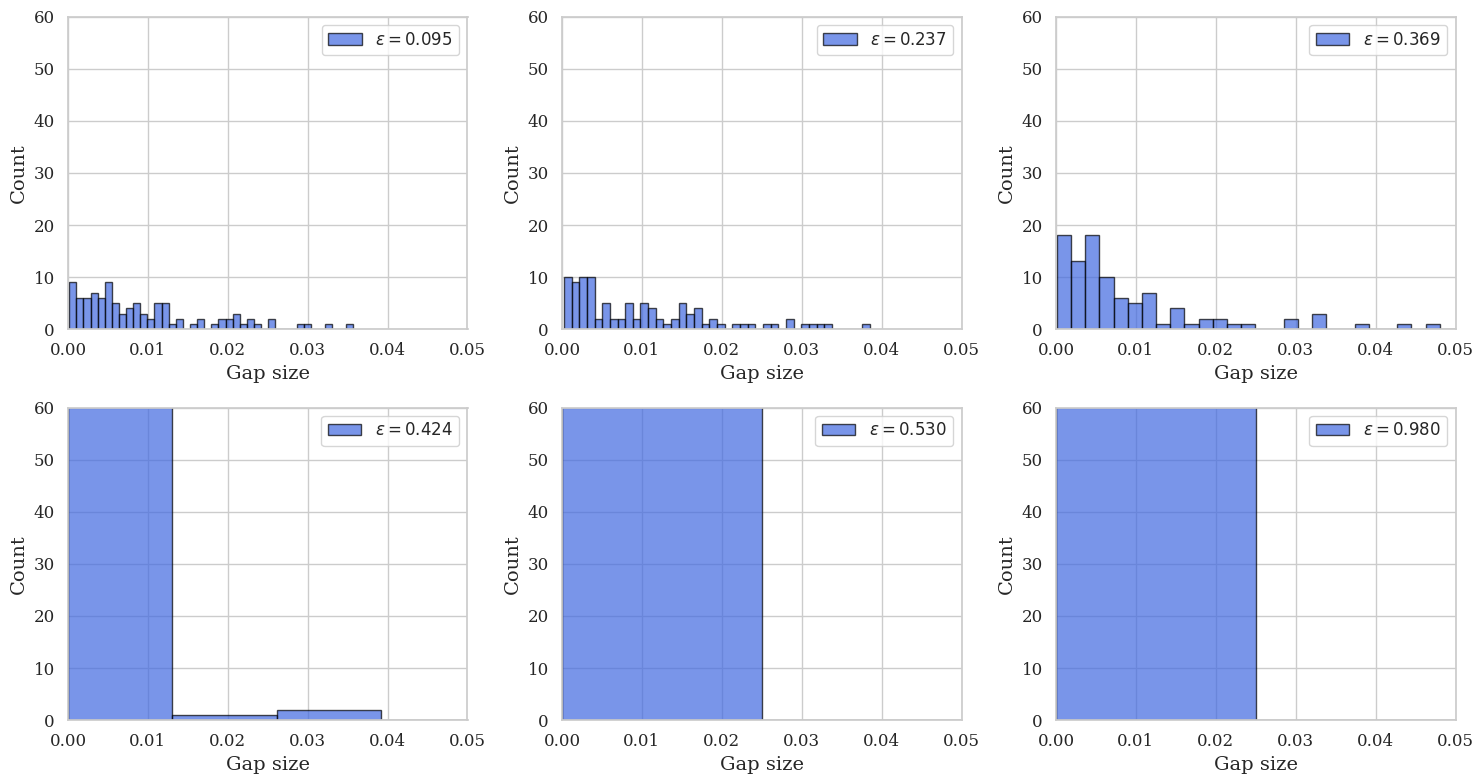

In [ ]:
eps_values = [0.095, 0.2373, 0.3686, 0.4242, 0.53, 0.98]
plot_gap_histograms(eps_values, N=100, T=1000, seed=42,
                    bins=40, run_number=3,
                    xlim=(0, 0.05), ylim=(0, 60))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_gap_histograms(eps_values, N=100, T=1000, b=4.0, seed=None,
                        bins=50, run_number=1,
                        xlim=None, ylim=None,
                        pdf_filename=None):
    """
    Plot 6 histograms of gap sizes for given epsilon values in 2x3 grid.
    All subplots share the same bin edges.
    """

    if len(eps_values) != 6:
        raise ValueError("Please provide exactly 6 epsilon values for a 2x3 grid.")

    sns.set(style="whitegrid")
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12
    })

    # Precompute data
    data_dict = {}
    all_gaps = []
    for eps in eps_values:
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)
        final_y = y_hist[-1]
        sorted_y = np.sort(final_y)
        gaps = np.diff(sorted_y)
        data_dict[eps] = gaps
        all_gaps.extend(gaps)

    # Compute global bin edges
    min_gap = np.min(all_gaps)
    max_gap = np.max(all_gaps)
    bin_edges = np.linspace(min_gap, max_gap, bins + 1)

    # --- Plot setup ---
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.flatten()

    for i, eps in enumerate(eps_values):
        gaps = data_dict[eps]

        axs[i].hist(gaps, bins=bin_edges, color='royalblue',
                    edgecolor='black', alpha=0.7,
                    label=fr"$\epsilon = {eps:.3f}$")
        axs[i].set_xlabel("Gap size")
        axs[i].set_ylabel("Count")
        axs[i].legend(loc="upper right", fontsize=12, frameon=True)

        if xlim is not None:
            axs[i].set_xlim(xlim)
        if ylim is not None:
            axs[i].set_ylim(ylim)

    plt.tight_layout()

    # Save as PDF
    if pdf_filename is None:
        pdf_filename = f"run{run_number}_hist.pdf"
    plt.savefig(pdf_filename, bbox_inches="tight", dpi=300)
    print(f"Plot saved as {pdf_filename}")

    # Show plot
    plt.show()
    plt.close(fig)


Plot saved as gap_histograms_run1.pdf


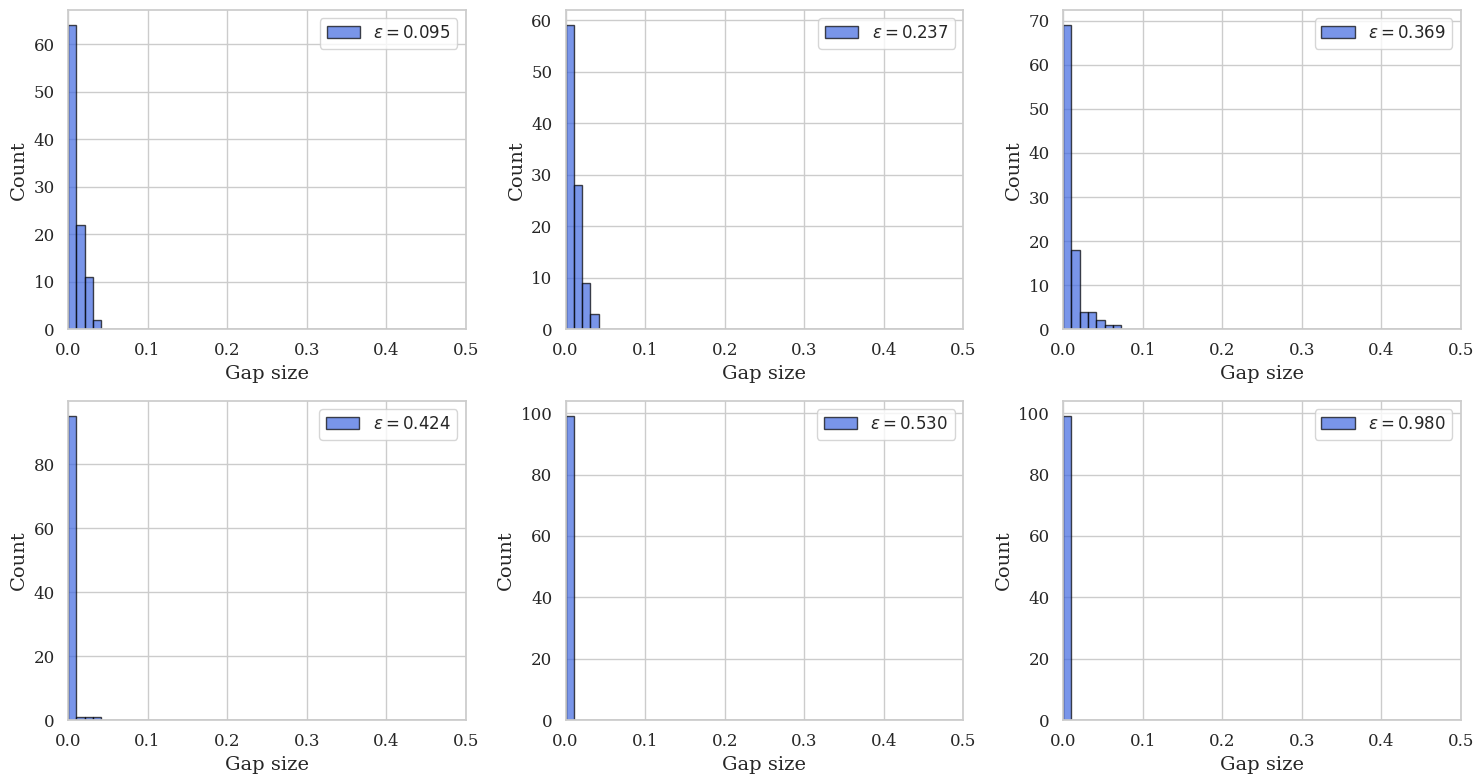

In [ ]:
eps_values = [0.095, 0.2373, 0.3686, 0.4242, 0.53, 0.98]
# Call the histogram plotting function
plot_gap_histograms(
    eps_values=eps_values,
    N=100,        # number of units
    T=1000,       # number of time steps
    b=4.0,        # parameter for the map
    seed=42,      # reproducibility
    bins=50,      # number of bins (same across all subplots)
    run_number=1, # used for default PDF filename
    xlim=(0, 0.5),    # optional x-axis limits
    ylim= None,    # optional y-axis limits
    pdf_filename="gap_histograms_run1.pdf"  # filename to save
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_gap_histograms_fixed_bin(eps_values, N=100, T=1000, b=4.0, seed=None,
                                  bins=50, run_number=1,
                                  xlim=None, ylim=None,
                                  pdf_filename=None):
    """
    Plot 6 histograms of gap sizes for given epsilon values in 2x3 grid.
    Uses a fixed bin width across all subplots (range / bins).
    """
    if len(eps_values) != 6:
        raise ValueError("Please provide exactly 6 epsilon values for a 2x3 grid.")

    sns.set(style="whitegrid")
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12
    })

    # Precompute data
    data_dict = {}
    all_gaps = []
    for eps in eps_values:
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)
        final_y = y_hist[-1]
        sorted_y = np.sort(final_y)
        gaps = np.diff(sorted_y)
        data_dict[eps] = gaps
        all_gaps.extend(gaps)

    all_gaps = np.array(all_gaps)

    # --- Fixed bin width ---
    bin_width = (np.max(all_gaps) - np.min(all_gaps)) / bins
    bin_edges = np.arange(np.min(all_gaps), np.max(all_gaps) + bin_width, bin_width)

    # --- Plot setup ---
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.flatten()

    for i, eps in enumerate(eps_values):
        gaps = data_dict[eps]

        axs[i].hist(gaps, bins=bin_edges, color='royalblue',
                    edgecolor='black', alpha=0.7,
                    label=fr"$\epsilon = {eps:.3f}$")
        axs[i].set_xlabel("Gap size")
        axs[i].set_ylabel("Count")
        axs[i].legend(loc="upper right", fontsize=12, frameon=True)

        if xlim is not None:
            axs[i].set_xlim(xlim)
        if ylim is not None:
            axs[i].set_ylim(ylim)

    plt.tight_layout()

    if pdf_filename is None:
        pdf_filename = f"run{run_number}_hist_fixed.pdf"
    plt.savefig(pdf_filename, bbox_inches="tight", dpi=300)
    print(f"Plot saved as {pdf_filename}")
    plt.show()
    plt.close(fig)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_gap_histograms_fd(eps_values, N=100, T=1000, b=4.0, seed=None,
                           run_number=1,
                           xlim=None, ylim=None,
                           pdf_filename=None):
    """
    Plot 6 histograms of gap sizes for given epsilon values in 2x3 grid.
    Bin width is computed using the Freedman–Diaconis rule.
    """
    if len(eps_values) != 6:
        raise ValueError("Please provide exactly 6 epsilon values for a 2x3 grid.")

    sns.set(style="whitegrid")
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12
    })

    # Precompute data
    data_dict = {}
    all_gaps = []
    for eps in eps_values:
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)
        final_y = y_hist[-1]
        sorted_y = np.sort(final_y)
        gaps = np.diff(sorted_y)
        data_dict[eps] = gaps
        all_gaps.extend(gaps)

    all_gaps = np.array(all_gaps)

    # --- Freedman–Diaconis bin width ---
    q75, q25 = np.percentile(all_gaps, [75, 25])
    iqr = q75 - q25
    n = len(all_gaps)
    bin_width = 2 * iqr / (n ** (1/3))
    if bin_width <= 0:
        # fallback in case of degenerate data
        bin_width = (np.max(all_gaps) - np.min(all_gaps)) / 50
    bin_edges = np.arange(np.min(all_gaps), np.max(all_gaps) + bin_width, bin_width)

    # --- Plot setup ---
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.flatten()

    for i, eps in enumerate(eps_values):
        gaps = data_dict[eps]

        axs[i].hist(gaps, bins=bin_edges, color='royalblue',
                    edgecolor='black', alpha=0.7,
                    label=fr"$\epsilon = {eps:.3f}$")
        axs[i].set_xlabel("Gap size")
        axs[i].set_ylabel("Count")
        axs[i].legend(loc="upper right", fontsize=12, frameon=True)

        if xlim is not None:
            axs[i].set_xlim(xlim)
        if ylim is not None:
            axs[i].set_ylim(ylim)

    plt.tight_layout()

    if pdf_filename is None:
        pdf_filename = f"run{run_number}_hist_fd.pdf"
    plt.savefig(pdf_filename, bbox_inches="tight", dpi=300)
    print(f"Plot saved as {pdf_filename}")
    plt.show()
    plt.close(fig)


Plot saved as run1_hist_fd.pdf


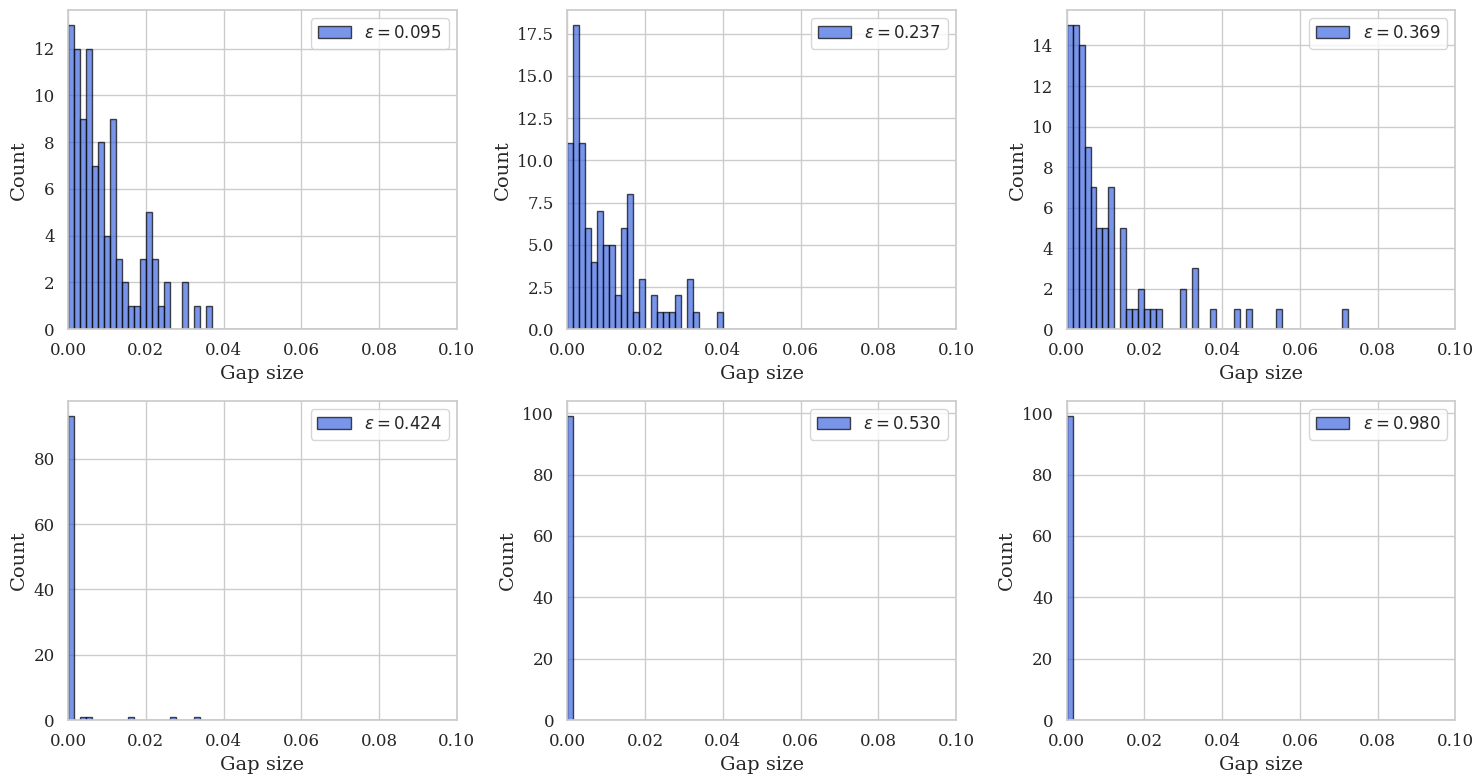

In [ ]:
eps_values = [0.095, 0.2373, 0.3686, 0.4242, 0.53, 0.98]


# Freedman–Diaconis
plot_gap_histograms_fd(eps_values, N=100, T=1000, b=4.0, seed=42,xlim=(0, 0.1))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_position_histograms_fd(eps_values, N=100, T=1000, b=4.0, seed=None,
                                run_number=1,
                                xlim=None, ylim=None,
                                pdf_filename=None):
    """
    Plot 6 histograms of node positions (final states at time T)
    for given epsilon values in a 2x3 grid.
    Bin width is computed using the Freedman–Diaconis rule
    across all positions.
    """
    if len(eps_values) != 6:
        raise ValueError("Please provide exactly 6 epsilon values for a 2x3 grid.")

    sns.set(style="whitegrid")
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12
    })

    # Precompute data
    data_dict = {}
    all_positions = []
    for eps in eps_values:
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)
        final_y = y_hist[-1]   # raw final states
        data_dict[eps] = final_y
        all_positions.extend(final_y)

    all_positions = np.array(all_positions)

    # --- Freedman–Diaconis bin width ---
    q75, q25 = np.percentile(all_positions, [75, 25])
    iqr = q75 - q25
    n = len(all_positions)
    bin_width = 2 * iqr / (n ** (1/3))
    if bin_width <= 0:
        # fallback in case of degenerate data
        bin_width = (np.max(all_positions) - np.min(all_positions)) / 50
    bin_edges = np.arange(np.min(all_positions), np.max(all_positions) + bin_width, bin_width)

    # --- Plot setup ---
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.flatten()

    for i, eps in enumerate(eps_values):
        positions = data_dict[eps]

        axs[i].hist(positions, bins=bin_edges, color='royalblue',
                    edgecolor='black', alpha=0.7,
                    label=fr"$\epsilon = {eps:.3f}$")
        axs[i].set_xlabel("Final state (y)")
        axs[i].set_ylabel("Count")
        axs[i].legend(loc="upper right", fontsize=12, frameon=True)

        if xlim is not None:
            axs[i].set_xlim(xlim)
        if ylim is not None:
            axs[i].set_ylim(ylim)

    plt.tight_layout()

    if pdf_filename is None:
        pdf_filename = f"run{run_number}_positions_fd.pdf"
    plt.savefig(pdf_filename, bbox_inches="tight", dpi=300)
    print(f"Plot saved as {pdf_filename}")
    plt.show()
    plt.close(fig)


Plot saved as final_positions_histograms.pdf


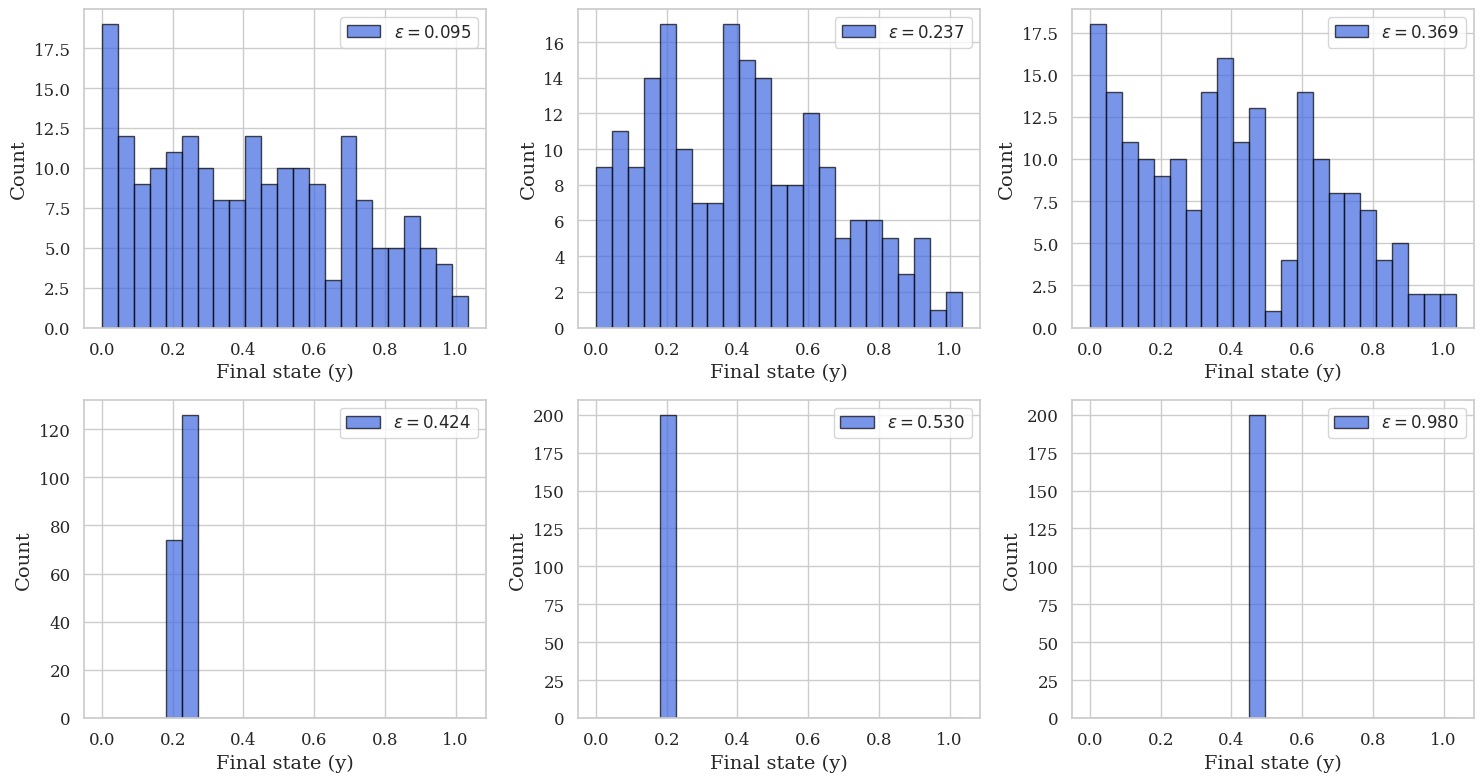

In [ ]:
# Example epsilon values (exactly 6 required)
eps_values = [0.095, 0.2373, 0.3686, 0.4242, 0.53, 0.98]
# Run the plotting function
plot_position_histograms_fd(
    eps_values=eps_values,
    N=200,          # system size
    T=2000,         # time steps
    b=4.0,          # skew parameter
    seed=42,        # RNG seed for reproducibility
    run_number=1,   # will be used in filename if pdf_filename not given
    pdf_filename="final_positions_histograms.pdf"  # custom filename
)

In [ ]:
import numpy as np
import plotly.graph_objects as go

def animate_gap_hist_with_highlights(
    epsilons,
    N=100,
    T=1000,
    b=4.0,
    seed=None,
    bins=20,
    epsilons_peaks=None,
    peak_color='crimson'
):
    frames = []
    data_dict = {}
    epsilons = list(epsilons)

    # Add missing peaks
    if epsilons_peaks is not None:
        for eps in epsilons_peaks:
            if eps not in epsilons:
                epsilons.append(eps)
        epsilons = sorted(epsilons)

    # Precompute trajectories
    for eps in epsilons:
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)
        final_y = y_hist[-1]
        data_dict[eps] = final_y

    # --- Compute global x and y limits ---
    global_max_count = 0
    global_min_gap, global_max_gap = np.inf, -np.inf

    for eps in epsilons:
        final_y = data_dict[eps]
        sorted_y = np.sort(final_y)
        gaps = np.diff(sorted_y)

        counts, bin_edges = np.histogram(gaps, bins=bins)
        global_max_count = max(global_max_count, counts.max())
        global_min_gap = min(global_min_gap, gaps.min())
        global_max_gap = max(global_max_gap, gaps.max())

    # Prepare frames
    for eps in epsilons:
        final_y = data_dict[eps]
        sorted_y = np.sort(final_y)
        gaps = np.diff(sorted_y)

        color = peak_color if (epsilons_peaks is not None and np.isclose(eps, epsilons_peaks).any()) else 'royalblue'

        hist = go.Histogram(
            x=gaps,
            nbinsx=bins,
            marker_color=color,
            name=f"ε = {eps:.3f}"
        )
        frame = go.Frame(data=[hist], name=f"{eps:.5f}")
        frames.append(frame)

    # Initial frame
    init_eps = epsilons[0]
    init_sorted_y = np.sort(data_dict[init_eps])
    init_gaps = np.diff(init_sorted_y)
    init_color = peak_color if (epsilons_peaks is not None and np.isclose(init_eps, epsilons_peaks).any()) else 'royalblue'
    init_hist = go.Histogram(x=init_gaps, nbinsx=bins, marker_color=init_color)

    fig = go.Figure(
        data=[init_hist],
        layout=go.Layout(
            title=f"Histogram of gap sizes between sorted points at final time (initial ε = {init_eps:.3f})",
            xaxis=dict(title="Gap size", range=[global_min_gap, global_max_gap]),
            yaxis=dict(title="Count", range=[0, global_max_count * 1.1]),
            updatemenus=[dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(label="Play", method="animate", args=[None, {"frame": {"duration": 400, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
                ]
            )]
        ),
        frames=frames
    )

    # Slider for epsilon
    sliders = [dict(
        steps=[dict(method='animate',
                    args=[[f"{eps:.5f}"], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                    label=f"{eps:.3f}") for eps in epsilons],
        transition={"duration": 0},
        x=0, y=0,
        currentvalue=dict(font=dict(size=16), prefix="ε = ", visible=True, xanchor='center'),
        len=1.0
    )]

    fig.update_layout(sliders=sliders)
    fig.show()


# -------------------
# Example usage
# -------------------
eps_array = np.linspace(0, 0.5, 101)   # main epsilon values
eps_peaks = [0.1313, 0.2373, 0.3686, 0.4242]      # special highlighted eps values

animate_gap_hist_with_highlights(
    epsilons=eps_array,
    N=100,
    T=1000,
    b=4.0,
    seed=42,
    bins=50,
    epsilons_peaks=eps_peaks
)


In [ ]:
import numpy as np
import plotly.graph_objects as go

def animate_gaps_over_epsilon(epsilons, N=100, T=1000, b=4.0, seed=None):
    frames = []
    data_dict = {}

    # Precompute trajectories and store final positions
    for eps in epsilons:
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)
        final_y = y_hist[-1]
        data_dict[eps] = final_y

    # Prepare frames for animation
    for eps in epsilons:
        final_y = data_dict[eps]
        sorted_y = np.sort(final_y)
        gaps = np.diff(sorted_y)

        hist = go.Bar(
            x=np.arange(len(gaps)),
            y=gaps,
            marker_color='royalblue',
            name=f"ε = {eps:.3f}"
        )
        frame = go.Frame(data=[hist], name=f"{eps:.5f}")
        frames.append(frame)

    # Initial frame
    init_eps = epsilons[0]
    init_sorted_y = np.sort(data_dict[init_eps])
    init_gaps = np.diff(init_sorted_y)
    init_hist = go.Bar(x=np.arange(len(init_gaps)), y=init_gaps, marker_color='royalblue')

    fig = go.Figure(
        data=[init_hist],
        layout=go.Layout(
            title=f"Distance between sorted points at final time over ε (initial ε = {init_eps:.3f})",
            xaxis=dict(title="Index of gap (between sorted points)"),
            yaxis=dict(title="Gap size"),
            updatemenus=[dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(label="Play", method="animate", args=[None, {"frame": {"duration": 400, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
                ]
            )]
        ),
        frames=frames
    )

    # Slider for epsilon
    sliders = [dict(
        steps=[dict(method='animate',
                    args=[[f"{eps:.5f}"], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                    label=f"{eps:.3f}") for eps in epsilons],
        transition={"duration": 0},
        x=0, y=0,
        currentvalue=dict(font=dict(size=16), prefix="ε = ", visible=True, xanchor='center'),
        len=1.0
    )]

    fig.update_layout(sliders=sliders)
    fig.show()

# Example usage:
eps_array = np.linspace(0, 0.5, 50)
animate_gaps_over_epsilon(eps_array, N=200, T=1000, b=4.0, seed=42)


In [ ]:
import numpy as np

def generate_data_dict(epsilons, N=100, T=1000, b=4.0, seed=None):
    """
    Runs the trajectory simulation for each epsilon and stores the final positions.

    Parameters
    ----------
    epsilons : array-like
        List/array of epsilon values to simulate.
    N : int
        Number of units.
    T : int
        Number of time steps.
    b : float
        System parameter.
    seed : int or None
        RNG seed for reproducibility.

    Returns
    -------
    data_dict : dict
        Keys = float epsilon values, Values = final positions (np.array of shape (N,))
    """
    data_dict = {}
    for eps in epsilons:
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=eps, b=b, seed=seed)
        final_y = y_hist[-1]
        data_dict[float(eps)] = final_y
    return data_dict


In [ ]:
eps_array = np.linspace(0, 0.5, 100)
data_dict = generate_data_dict(eps_array, N=100, T=1000, b=4.0, seed=42)

